Setting up the environment

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import rasterio
import torch
from torch import nn
from torch.utils.data import Dataset,random_split,DataLoader

# Importing the U-Net model
from models import Unet

In [3]:
class Sentinel1Dataset(Dataset):
    def __init__(self, chip_info_file, transform=None, target_transform=None):
        self.chip_df = pd.read_csv(chip_info_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.chip_df)

    def __getitem__(self, idx):
        img_vv_path = self.chip_df.iloc[idx, 0]        
        img_vh_path = self.chip_df.iloc[idx, 1]
        dem_path = self.chip_df.iloc[idx, 2]
        pwat_path = self.chip_df.iloc[idx, 3]
        
        with rasterio.open(img_vv_path) as src_vv:
            img_vv = src_vv.read(1)
            img_vv = np.clip(img_vv,-50,25)
        with rasterio.open(img_vh_path) as src_vh:
            img_vh = src_vh.read(1)
            img_vh = np.clip(img_vh,-50,25)
        with rasterio.open(dem_path) as elevation:
            ele = elevation.read(1)
            ele = np.clip(ele,0.0,2000.0)
        with rasterio.open(pwat_path) as pwater:
            wat = pwater.read(1)
            wat = np.clip(wat,0.0,100.0)            
            
        # Normalization        
        img_vv_norm = (img_vv - (-50)) / (25 - (-50))
        img_vh_norm = (img_vh - (-50)) / (25 - (-50))
        ele_norm = ele/2000.0
        wat_norm = wat/100.0
        
        image = torch.stack((torch.from_numpy(img_vv_norm),
                             torch.from_numpy(img_vh_norm),
                             torch.from_numpy(ele_norm),
                             torch.from_numpy(wat_norm),))
            
        label_path = self.chip_df.iloc[idx, 4]
        with rasterio.open(label_path) as src_label:
            label = src_label.read(1)
        label = torch.from_numpy(label).to(torch.float32)
        label = torch.unsqueeze(label, 0)
    
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
test_data = Sentinel1Dataset('data/chip_test.csv')
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
#Saved model paths
# model: based on dataset with more than 30% chip water percentage
PATH1 = "D:\Pytorch-UNet-Flood-Segmentation\models\model_20230411_161404_31"
model1 = Unet(4,1).to(device)
model1.load_state_dict(torch.load(PATH1))
# model: based on dataset with less than 30% chip water percentage
PATH2 = "D:\Pytorch-UNet-Flood-Segmentation\models\model_20230412_015857_48"
model2 = Unet(4,1).to(device)
model2.load_state_dict(torch.load(PATH2))

#Loss function
loss_fn = torch.nn.BCELoss()

In [7]:
def IoU(pred, true):
    pred = np.where(pred>0.5,1,0)
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)   
    iou = intersection.sum()/(union.sum()+0.0000001)
    return iou

Model Inference

In [9]:
def inference(dataloader, model1, model2):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model1.eval()
    model2.eval()

    dataloader_idx = 0
    last_iou1, running_iou1 = 0, 0
    last_iou2, running_iou2 = 0, 0
    last_iou_c, running_iou_c = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred1 = model1(X)
            pred1 = pred1.cpu().detach().numpy()
            pred2 = model2(X)
            pred2 = pred2.cpu().detach().numpy()            
            
            pred1 = np.where(pred1>0.5,1,0)
            pred2 = np.where(pred2>0.5,1,0)
            pred= np.maximum(pred1, pred2)
            #pred=np.where(pred>0.5,1,0)
            y = y.cpu().detach().numpy()
            
            dataloader_idx += 1
            np.save(os.path.join('D:\Pytorch-UNet-Flood-Segmentation\predictions\model1',f'np_{dataloader_idx}.npy'), pred1)
            np.save(os.path.join('D:\Pytorch-UNet-Flood-Segmentation\predictions\model2',f'np_{dataloader_idx}.npy'), pred2)
            np.save(os.path.join('D:\Pytorch-UNet-Flood-Segmentation\predictions\combined',f'np_{dataloader_idx}.npy'), pred)
            
            iou1 = IoU(pred1, y)
            iou2 = IoU(pred2, y)
            iou_c = IoU(pred, y)
            running_iou1 += iou1
            running_iou2 += iou2
            running_iou_c += iou_c
            
    #last_loss = running_loss/num_batches
    last_iou1 = running_iou1/num_batches
    last_iou2 = running_iou2/num_batches
    last_iou_c = running_iou_c/num_batches
    
    print(f"\n Accuracy model 1 IOU                : {(last_iou1):>8f}%")
    print(f"\n Accuracy model 2 IOU                : {(last_iou2):>8f}%")
    print(f"\n Accuracy model 1 and 2 combined IOU : {(last_iou_c):>8f}%")

    return last_iou1,last_iou2,last_iou_c

In [10]:
# Inference
test_avg_iou = inference(test_dataloader, model1, model2)


 Accuracy model 1 IOU                : 0.866739%

 Accuracy model 2 IOU                : 0.788409%

 Accuracy model 1 and 2 combined IOU : 0.876500%


Visualizing the results

In [11]:
df_test = pd.read_csv('data/chip_test.csv')
arr_list_c = glob.glob(os.path.join('D:\Pytorch-UNet-Flood-Segmentation\predictions\combined','*npy'))
arr_list_1 = glob.glob(os.path.join('D:\Pytorch-UNet-Flood-Segmentation\predictions\model1','*npy'))
arr_list_2 = glob.glob(os.path.join('D:\Pytorch-UNet-Flood-Segmentation\predictions\model2','*npy'))

single_arr_list_1 = []
single_arr_list_2 = []
single_arr_list_c = []

for x in range(len(arr_list_1)):
    arr = np.load(arr_list_1[x])
    for y in range(len(arr)):
        single_arr_list_1.append(arr[y][0])
for x in range(len(arr_list_2)):
    arr = np.load(arr_list_2[x])
    for y in range(len(arr)):
        single_arr_list_2.append(arr[y][0])      
for x in range(len(arr_list_c)):
    arr = np.load(arr_list_c[x])
    for y in range(len(arr)):
        single_arr_list_c.append(arr[y][0])      

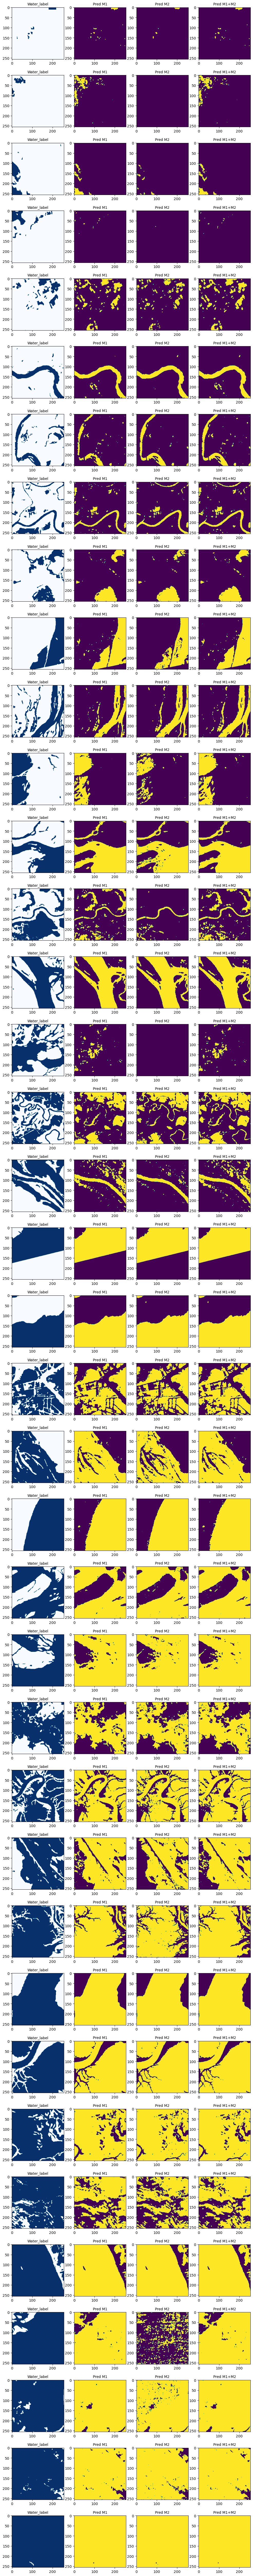

In [12]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
fig, axs = plt.subplots(nrows=len(single_arr_list_1), ncols=4,figsize=(12,130))

for j in range(len(df_test['label'])):
    water_label = rasterio.open(df_test['label'][j])
    band = water_label.read(1)
    axs[j,0].imshow(band,cmap='Blues')
    axs[j,0].set_title('Water_label', fontsize=10) 
    water_label.close()
    axs[j,1].imshow(single_arr_list_1[j],cmap='viridis')
    axs[j,1].set_title('Pred M1', fontsize=10)
    axs[j,2].imshow(single_arr_list_2[j],cmap='viridis')
    axs[j,2].set_title('Pred M2', fontsize=10)
    axs[j,3].imshow(single_arr_list_c[j],cmap='viridis')
    axs[j,3].set_title('Pred M1+M2', fontsize=10)